In [1]:
pip install nibabel

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tensorflow

  Using cached tensorflow-2.9.1-cp39-cp39-win_amd64.whl (444.0 MB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached tensorflow_estimator-2.9.0-py2.py3-none-any.whl (438 kB)
  Using cached protobuf-3.19.4-cp39-cp39-win_amd64.whl (895 kB)
  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
  Using cached tensorboard-2.9.1-py3-none-any.whl (5.8 MB)
  Using cached keras-2.9.0-py2.py3-none-any.whl (1.6 MB)
Note: you may need to restart the kernel to use updated packages.


ERROR: Exception:
Traceback (most recent call last):
  File "C:\Users\Hp\anaconda3\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 3021, in _dep_map
    return self.__dep_map
  File "C:\Users\Hp\anaconda3\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Hp\anaconda3\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 3012, in _parsed_pkg_info
    return self._pkg_info
  File "C:\Users\Hp\anaconda3\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _pkg_info

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Hp\anaconda3\lib\site-packages\pip\_internal\cli\base_command.py", line 173

In [3]:
import numpy as np
import nibabel as nib
import glob
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tifffile import imsave

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [4]:
tf.__version__

'2.8.0'

In [5]:
TRAIN_DATASET_PATH = r"D:/DATASET/archive/BraTS2021_Training_Data/"

#VALIDATION_DATASET_PATH = 'BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'

In [6]:
#Loading single image

test_image_flair=nib.load(TRAIN_DATASET_PATH + "BraTS2021_00005/BraTS2021_00005_flair.nii.gz").get_fdata()
print(test_image_flair.max())

3703.0


In [7]:
print(test_image_flair.min())

0.0


In [8]:
#Scalers are applied to 1D so let us reshape and then reshape back to original shape. 
test_image_flair=scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)

In [9]:
test_image_t1=nib.load(TRAIN_DATASET_PATH + "BraTS2021_00005/BraTS2021_00005_t1.nii.gz").get_fdata()
test_image_t1=scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)

In [10]:
test_image_t1ce=nib.load(TRAIN_DATASET_PATH + "BraTS2021_00005/BraTS2021_00005_t1ce.nii.gz").get_fdata()
test_image_t1ce=scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

In [11]:
test_image_t2=nib.load(TRAIN_DATASET_PATH + "BraTS2021_00005/BraTS2021_00005_t2.nii.gz").get_fdata()
test_image_t2=scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

In [12]:
test_mask=nib.load(TRAIN_DATASET_PATH + "BraTS2021_00005/BraTS2021_00005_seg.nii.gz").get_fdata()
test_mask=test_mask.astype(np.uint8)

In [13]:
print(np.unique(test_mask))  #0, 1, 2, 4 (Need to reencode to 0, 1, 2, 3)
test_mask[test_mask==4] = 3  #Reassign mask values 4 to 3
print(np.unique(test_mask)) 

[0 1 2 4]
[0 1 2 3]


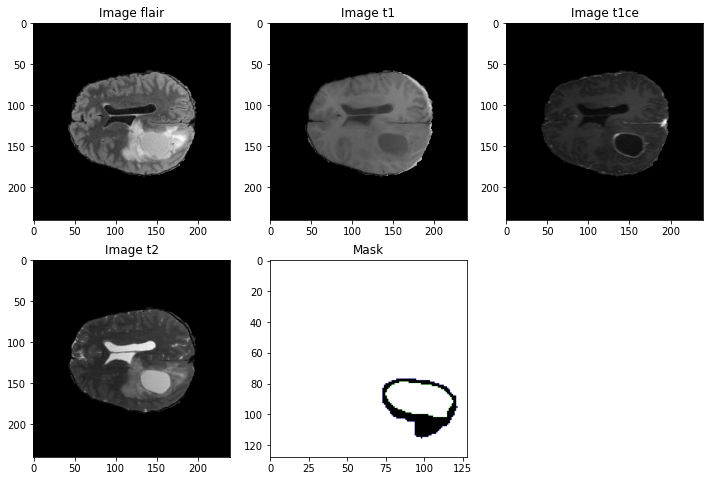

In [70]:
import random
n_slice=random.randint(0, test_mask.shape[2])

plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.imshow(test_image_flair[:,:,n_slice], cmap='gray')
plt.title('Image flair')
plt.subplot(232)
plt.imshow(test_image_t1[:,:,n_slice], cmap='gray')
plt.title('Image t1')
plt.subplot(233)
plt.imshow(test_image_t1ce[:,:,n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(234)
plt.imshow(test_image_t2[:,:,n_slice], cmap='gray')
plt.title('Image t2')
plt.subplot(235)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [15]:
##################################################
#PART 2: Explore the process of combining images to channels and divide them to patches
#Includes...
#Combining all 4 images to 4 channels of a numpy array.
#
################################################
#Flair, T1CE, annd T2 have the most information
#Combine t1ce, t2, and flair into single multichannel image

combined_x = np.stack([test_image_flair, test_image_t1ce, test_image_t2], axis=3)

In [16]:
#Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches. 
#cropping x, y, and z
#combined_x=combined_x[24:216, 24:216, 13:141]

combined_x=combined_x[56:184, 56:184, 13:141] #Crop to 128x128x128x4

In [17]:
#Do the same for mask
test_mask = test_mask[56:184, 56:184, 13:141]

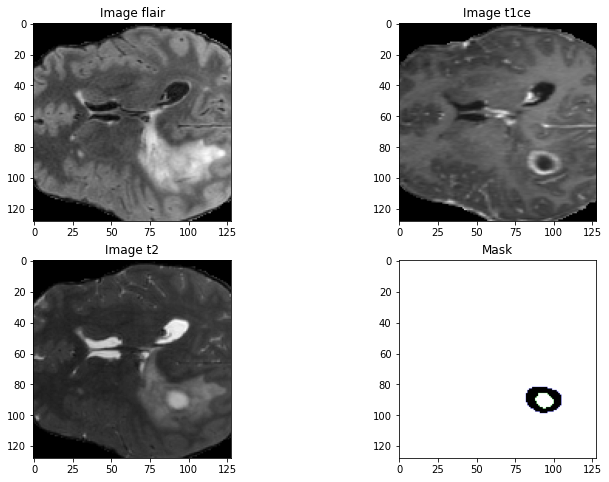

In [69]:
n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(combined_x[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(combined_x[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(combined_x[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [19]:
imsave('D:/DATASET/archive/combined00005.tif', combined_x)
np.save('D:/DATASET/archive/combined00005.npy', combined_x)

In [20]:
#Verify image is being read properly
#my_img=imread('BraTS2020_TrainingData/combined255.tif')

my_img=np.load('D:/DATASET/archive/combined00005.npy')

test_mask = to_categorical(test_mask, num_classes=4)

In [21]:
#End of understanding the dataset. Now get it organized.
#####################################

#Now let us apply the same as above to all the images...
#Merge channels, crop, patchify, save
#GET DATA READY =  GENERATORS OR OTHERWISE

In [67]:
#Keras datagenerator does ntot support 3d

# # # images lists harley

t1_list = sorted(glob.glob('D:/DATASET/archive/BraTS2021_Training_Data/*/*t1.nii.gz'))
t2_list = sorted(glob.glob('D:/DATASET/archive/BraTS2021_Training_Data/*/*t2.nii.gz'))
t1ce_list = sorted(glob.glob('D:/DATASET/archive/BraTS2021_Training_Data/*/*t1ce.nii.gz'))
flair_list = sorted(glob.glob('D:/DATASET/archive/BraTS2021_Training_Data/*/*flair.nii.gz'))
mask_list = sorted(glob.glob('D:/DATASET/archive/BraTS2021_Training_Data/*/*seg.nii.gz'))

In [68]:
for img in range(len(t2_list)):   #Using t1_list as all lists are of same size
    print("Now preparing image and masks number: ", img)
      
    temp_image_t2=nib.load(t2_list[img]).get_fdata()
    temp_image_t2=scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)
   
    temp_image_t1ce=nib.load(t1ce_list[img]).get_fdata()
    temp_image_t1ce=scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)
   
    temp_image_flair=nib.load(flair_list[img]).get_fdata()
    temp_image_flair=scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)
        
    temp_mask=nib.load(mask_list[img]).get_fdata()
    temp_mask=temp_mask.astype(np.uint8)
    temp_mask[temp_mask==4] = 3  #Reassign mask values 4 to 3
    #print(np.unique(temp_mask))
    
    
    temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)
    
    #Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches. 
    #cropping x, y, and z
    temp_combined_images=temp_combined_images[56:184, 56:184, 13:141]
    temp_mask = temp_mask[56:184, 56:184, 13:141]
    
    val, counts = np.unique(temp_mask, return_counts=True)
    
    if (1 - (counts[0]/counts.sum())) > 0.01:  #At least 1% useful volume with labels that are not 0
        print("Save Me")
        temp_mask= to_categorical(temp_mask, num_classes=4)
        np.save('D:/DATASET/archive/input_data_3channels/images/image_'+str(img)+'.npy', temp_combined_images)
        np.save('D:/DATASET/archive/input_data_3channels//masks/mask_'+str(img)+'.npy', temp_mask)
        
    else:
        print("I am useless")   

Now preparing image and masks number:  0
Save Me
Now preparing image and masks number:  1
Save Me
Now preparing image and masks number:  2
Save Me
Now preparing image and masks number:  3
Save Me
Now preparing image and masks number:  4
Save Me
Now preparing image and masks number:  5
I am useless
Now preparing image and masks number:  6
I am useless
Now preparing image and masks number:  7
Save Me
Now preparing image and masks number:  8
Save Me
Now preparing image and masks number:  9
Save Me
Now preparing image and masks number:  10
Save Me
Now preparing image and masks number:  11
Save Me
Now preparing image and masks number:  12
Save Me
Now preparing image and masks number:  13
Save Me
Now preparing image and masks number:  14
Save Me
Now preparing image and masks number:  15
Save Me
Now preparing image and masks number:  16
Save Me
Now preparing image and masks number:  17
Save Me
Now preparing image and masks number:  18
Save Me
Now preparing image and masks number:  19
Save Me


In [71]:
pip install split-folders

Note: you may need to restart the kernel to use updated packages.


In [72]:
import splitfolders  # or import split_folders

In [73]:
input_folder = 'D:/DATASET/archive/input_data_3channels/'
output_folder = 'D:/DATASET/archive/input_data_1151/'

In [74]:
# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.75, .25), group_prefix=None) # default values

Copying files: 2302 files [2:04:20,  3.24s/ files]


In [79]:
#from tifffile import imsave, imread
import os
import numpy as np


def load_img(img_dir, img_list):
    images=[]
    for i, image_name in enumerate(img_list):    
        if (image_name.split('.')[1] == 'npy'):
            
            image = np.load(img_dir+image_name)
                      
            images.append(image)
    images = np.array(images)
    
    return(images)


In [81]:
def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):

    L = len(img_list)

    #keras needs the generator infinite, so we will use while true  
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
                       
            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])

            yield (X,Y) #a tuple with two numpy arrays with batch_size samples     

            batch_start += batch_size   
            batch_end += batch_size

In [83]:
#Test the generator

from matplotlib import pyplot as plt
import random

train_img_dir = "D:/DATASET/archive/input_data_1151/train/images/"
train_mask_dir = "D:/DATASET/archive/input_data_1151/train/masks/"
train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)


In [91]:
#Verify generator.... In python 3 next() is renamed as __next__()
img, msk = train_img_datagen.__next__()

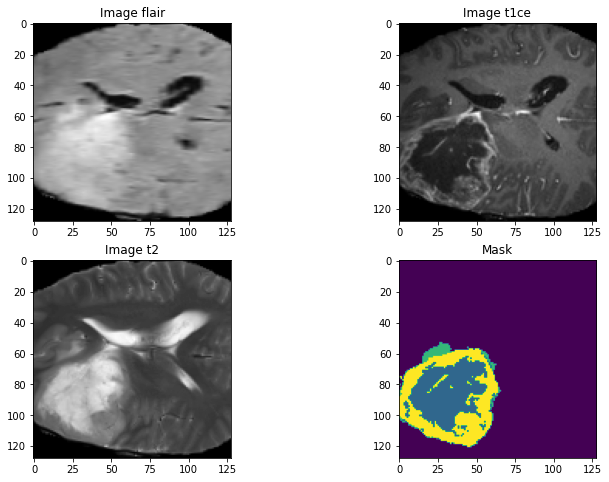

In [92]:
img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [100]:
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from keras.metrics import MeanIoU

In [101]:
kernel_initializer =  'he_uniform' #Try others if you want


In [102]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential  #removed python from each layer
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np

#print(tf.__version__)

In [103]:
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)
    
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)
     
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)
     
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)
     
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)
    
    #Expansive path 
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)
     
    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)
     
    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)
     
    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)
     
    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    #compile model outside of this function to make it flexible. 
    model.summary()
    
    return model

In [104]:
#Test if everything is working ok. 
model = simple_unet_model(128, 128, 128, 3, 4)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d (Conv3D)                (None, 128, 128, 12  1312        ['input_1[0][0]']                
                                8, 16)                                                            
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 12  0           ['conv3d[0][0]']                 
                                8, 16)                                                        

In [105]:
print(model.input_shape)
print(model.output_shape)

(None, 128, 128, 128, 3)
(None, 128, 128, 128, 4)


In [107]:
import os
import numpy as np
#from custom_datagen import imageLoader
#import tensorflow as tf
import keras
from matplotlib import pyplot as plt
import glob
import random

In [112]:
train_img_dir = "D:/DATASET/archive/input_data_1151/train/images/"
train_mask_dir = "D:/DATASET/archive/input_data_1151/train/masks/"
img_list=os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

In [123]:
num_images = len(os.listdir(train_img_dir))

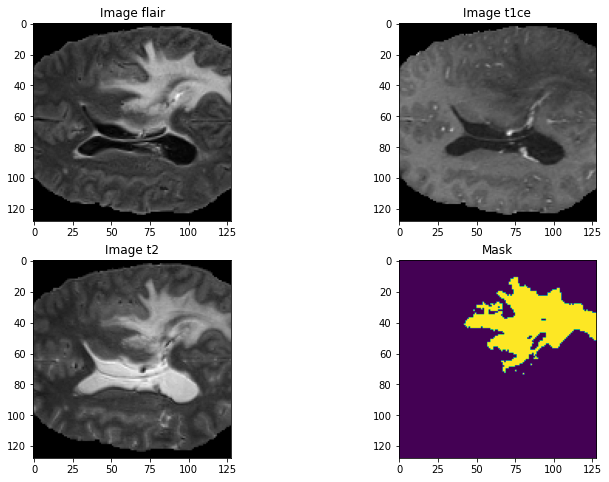

In [125]:
img_num = random.randint(0,num_images-1)
test_img = np.load(train_img_dir+img_list[img_num])
test_mask = np.load(train_mask_dir+msk_list[img_num])
test_mask = np.argmax(test_mask, axis=3)


n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()


In [126]:
#Optional step of finding the distribution of each class and calculating appropriate weights
#Alternatively you can just assign equal weights and see how well the model performs: 0.25, 0.25, 0.25, 0.25

import pandas as pd
columns = ['0','1', '2', '3']
df = pd.DataFrame(columns=columns)
train_mask_list = sorted(glob.glob('D:/DATASET/archive/input_data_1151/train/masks/*.npy'))
for img in range(len(train_mask_list)):
    print(img)
    temp_image=np.load(train_mask_list[img])
    temp_image = np.argmax(temp_image, axis=3)
    val, counts = np.unique(temp_image, return_counts=True)
    zipped = zip(columns, counts)
    conts_dict = dict(zipped)
    
    df = df.append(conts_dict, ignore_index=True)

label_0 = df['0'].sum()
label_1 = df['1'].sum()
label_2 = df['1'].sum()
label_3 = df['3'].sum()
total_labels = label_0 + label_1 + label_2 + label_3
n_classes = 4
#Class weights claculation: n_samples / (n_classes * n_samples_for_class)
wt0 = round((total_labels/(n_classes*label_0)), 2) #round to 2 decimals
wt1 = round((total_labels/(n_classes*label_1)), 2)
wt2 = round((total_labels/(n_classes*label_2)), 2)
wt3 = round((total_labels/(n_classes*label_3)), 2)

#Weights are: 0.26, 22.53, 22.53, 26.21
#wt0, wt1, wt2, wt3 = 0.26, 22.53, 22.53, 26.21
#These weihts can be used for Dice loss 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [127]:
#Define the image generators for training and validation

train_img_dir = "D:/DATASET/archive/input_data_1151/train/images/"
train_mask_dir = "D:/DATASET/archive/input_data_1151/train/masks/"

val_img_dir = "D:/DATASET/archive/input_data_1151/val/images/"
val_mask_dir = "D:/DATASET/archive/input_data_1151/val/masks/"

train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list=os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)

In [128]:
batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)


In [131]:
#Verify generator.... In python 3 next() is renamed as __next__()
img, msk = train_img_datagen.__next__()

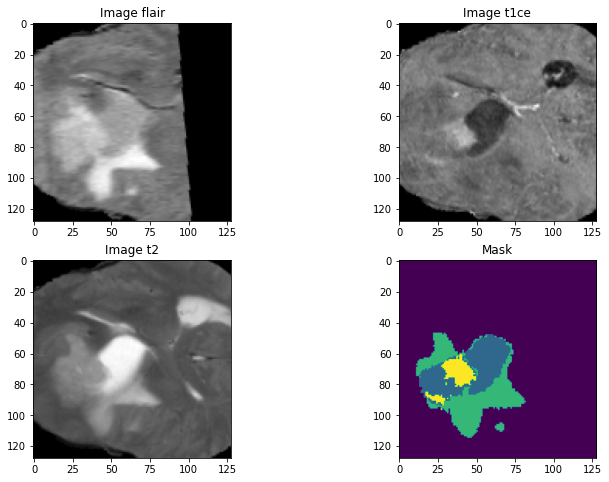

In [135]:
img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [203]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [214]:
pip install segmentation-models

  Using cached segmentation_models-1.0.1-py3-none-any.whl (33 kB)
  Using cached Keras_Applications-1.0.8-py3-none-any.whl (50 kB)
  Using cached efficientnet-1.0.0-py3-none-any.whl (17 kB)
  Using cached image_classifiers-1.0.0-py3-none-any.whl (19 kB)
Note: you may need to restart the kernel to use updated packages.


ERROR: Exception:
Traceback (most recent call last):
  File "C:\Users\Hp\anaconda3\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 3021, in _dep_map
    return self.__dep_map
  File "C:\Users\Hp\anaconda3\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Hp\anaconda3\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 3012, in _parsed_pkg_info
    return self._pkg_info
  File "C:\Users\Hp\anaconda3\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _pkg_info

During handling of the above exception, another exception occurred:

Traceback (most recent call last):


  File "C:\Users\Hp\anaconda3\lib\site-packages\pip\_internal\cli\base_command.py", line 173, in _main
    status = self.run(options, args)
  File "C:\Users\Hp\anaconda3\lib\site-packages\pip\_internal\cli\req_command.py", line 203, in wrapper
    return func(self, options, args)
  File "C:\Users\Hp\anaconda3\lib\site-packages\pip\_internal\commands\install.py", line 315, in run
    requirement_set = resolver.resolve(
  File "C:\Users\Hp\anaconda3\lib\site-packages\pip\_internal\resolution\resolvelib\resolver.py", line 94, in resolve
    result = self._result = resolver.resolve(
  File "C:\Users\Hp\anaconda3\lib\site-packages\pip\_vendor\resolvelib\resolvers.py", line 472, in resolve
    state = resolution.resolve(requirements, max_rounds=max_rounds)
  File "C:\Users\Hp\anaconda3\lib\site-packages\pip\_vendor\resolvelib\resolvers.py", line 366, in resolve
    failure_causes = self._attempt_to_pin_criterion(name)
  File "C:\Users\Hp\anaconda3\lib\site-packages\pip\_vendor\resolvelib\res

In [219]:
pip install -U segmentation-models

  Using cached segmentation_models-1.0.1-py3-none-any.whl (33 kB)
  Using cached image_classifiers-1.0.0-py3-none-any.whl (19 kB)
  Using cached efficientnet-1.0.0-py3-none-any.whl (17 kB)
  Using cached Keras_Applications-1.0.8-py3-none-any.whl (50 kB)
Note: you may need to restart the kernel to use updated packages.


ERROR: Exception:
Traceback (most recent call last):
  File "C:\Users\Hp\anaconda3\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 3021, in _dep_map
    return self.__dep_map
  File "C:\Users\Hp\anaconda3\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Hp\anaconda3\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 3012, in _parsed_pkg_info
    return self._pkg_info
  File "C:\Users\Hp\anaconda3\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _pkg_info

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Hp\anaconda3\lib\site-packages\pip\_internal\cli\base_command.py", line 173

In [220]:
pip install -U --pre segmentation-models

  Using cached segmentation_models-1.0.1-py3-none-any.whl (33 kB)
  Using cached image_classifiers-1.0.0-py3-none-any.whl (19 kB)
  Using cached Keras_Applications-1.0.8-py3-none-any.whl (50 kB)
  Using cached efficientnet-1.0.0-py3-none-any.whl (17 kB)
Note: you may need to restart the kernel to use updated packages.


ERROR: Exception:
Traceback (most recent call last):
  File "C:\Users\Hp\anaconda3\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 3021, in _dep_map
    return self.__dep_map
  File "C:\Users\Hp\anaconda3\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Hp\anaconda3\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 3012, in _parsed_pkg_info
    return self._pkg_info
  File "C:\Users\Hp\anaconda3\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _pkg_info

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Hp\anaconda3\lib\site-packages\pip\_internal\cli\base_command.py", line 173

In [221]:
pip install git+https://github.com/qubvel/segmentation_models

Note: you may need to restart the kernel to use updated packages.


  Running command git clone -q https://github.com/qubvel/segmentation_models 'C:\Users\Hp\AppData\Local\Temp\pip-req-build-54yjw1d6'
  Running command git submodule update --init --recursive -q


  Cloning https://github.com/qubvel/segmentation_models to c:\users\hp\appdata\local\temp\pip-req-build-54yjw1d6
  Resolved https://github.com/qubvel/segmentation_models to commit e951c6747f75fa9e7240816d1c79dd2e66813123
  Using cached Keras_Applications-1.0.8-py3-none-any.whl (50 kB)
  Using cached image_classifiers-1.0.0-py3-none-any.whl (19 kB)
  Using cached efficientnet-1.0.0-py3-none-any.whl (17 kB)


ERROR: Exception:
Traceback (most recent call last):
  File "C:\Users\Hp\anaconda3\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 3021, in _dep_map
    return self.__dep_map
  File "C:\Users\Hp\anaconda3\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Hp\anaconda3\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 3012, in _parsed_pkg_info
    return self._pkg_info
  File "C:\Users\Hp\anaconda3\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _pkg_info

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Hp\anaconda3\lib\site-packages\pip\_internal\cli\base_command.py", line 173

In [222]:
###########################################################################
#Define loss, metrics and optimizer to be used for training
wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25
import segmentation_models_3D as sm
dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]

LR = 0.0001
optim = keras.optimizers.Adam(LR)

ModuleNotFoundError: No module named 'segmentation_models_3D'